## CAM Pseudo-Mask Production pipeline

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install tiatoolbox seaborn | tail -n 1
ON_GPU=False
print('Installation is done.')
!pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user
ON_GPU = True 
!pip install seaborn
!pip install Pillow==9.0.0
!pip install validators matplotlib
!pip install torch-summary
!pip uninstall matplotlib
!pip install matplotlib==3.1.3
!pip install captum
!pip install segmentation_models_pytorch
!pip install torchmetrics

Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Installation is done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html
     |████████████████████████████████| 831.4 MB 6.5 kB/s 
     |████████████████████████████████| 22.1 MB 721 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.9.1+cu102 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.1+cu102 which is incompatible.
tiatoolbox 1.2.1 requires torch>=1.11.0, but you have torch 1.9.1+cu102 which is incompatible.
tiatoolbox 1.2.1 requires torchvision>=0.12.0, but you have torchvision 0.10.1+cu102 which is incompatib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=95423b95ce2dee9d285819f4516aba83c8d20a2fcd401edb3008cd41c053ea74
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.4 MB/s 
     |████████████████████████████████| 376 kB 22.9 MB/s 
     |████████████████████████████████| 58 kB 8.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=56cb15dacb3fabae42d6ac1ea9edf654123aaa8c956f7fab316b81807e3e2983
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=108bca35b8d26e3dc00fff956e98528b89a4dfbfa5056d1fa6a3251ba6735636
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tables
import cv2
from PIL import Image
from random import randint 
import torchvision
import tables as pt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torch.nn.functional as P
import random
import sys
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
import numpy as np
from tiatoolbox.tools import patchextraction
import time
import os
import copy
from sklearn.metrics import cohen_kappa_score,precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
import pickle
import PIL 
from torchsummary import summary
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from tiatoolbox.models.engine.semantic_segmentor import (
    IOSegmentorConfig,
    SemanticSegmentor,
)
import math
from google.colab.patches import cv2_imshow
from tqdm import tqdm

from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
from google.colab.patches import cv2_imshow
from skimage.morphology import reconstruction
from tiatoolbox.tools.tissuemask import MorphologicalMasker
plt.style.use('seaborn')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates that images will be saved as unsigned int 8 bit, i.e., [0,255]
filenameAtom = tables.StringAtom(itemsize=255) #create an atom to store the filename of the image, just incase we need it later, 
training_directory = '/content/gdrive/MyDrive/1.training/1.training/'
validation_directory = '/content/gdrive/MyDrive/2.validation/2.validation/'
testing_directory = '/content/gdrive/MyDrive/3.testing/3.testing/'


In [ ]:
#Match the ground truth to the training image
X_image_strings = list()
training_y = list()

for image_string in os.listdir(training_directory):
  X_image_strings.append(os.path.join(training_directory,image_string))
  new_string = image_string[-13:-4].strip()
  new_label= [int(new_string[-8]),int(new_string[-5]),int(new_string[-2])]
  training_y.append(np.array(new_label))

In [ ]:
non_single_class_images = list()
non_single_class_images_y = list()
only_tumour_i = list()
only_stroma_i = list()
only_normal_i = list()
listing_dir = os.listdir(training_directory)
for i in range(len(listing_dir)):
   io=cv2.cvtColor(cv2.imread(training_directory+listing_dir[i]),cv2.COLOR_BGR2RGB)
   interp_method=PIL.Image.BICUBIC
   io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
   io = cv2.resize(io,(224,224))

   if all(training_y[i] == [1,0,0]):
      only_tumour_i.append(io)
   elif all(training_y[i] == [0,1,0]):
      only_stroma_i.append(io)
   elif all(training_y[i] == [0,0,1]):
      only_normal_i.append(io)
   else:
     non_single_class_images.append(io)
     non_single_class_images_y.append(training_y[i])



In [ ]:
def create_background_mask_two(image,threshold):
  background_map =  np.zeros((224,224),dtype=np.uint8)
  kernel = np.ones((3,3),np.uint8)
  for i in range(224):
    for j in range(224):
      if all(pixel>= threshold for pixel in image[i][j]):
        background_map[i][j] = 255
      else:
        background_map[i][j] = 0
  joe = cv2.morphologyEx(background_map, cv2.MORPH_CLOSE, kernel)
  final = cv2.erode(joe,kernel,iterations = 1)


  return final 

(-0.5, 223.5, 223.5, -0.5)

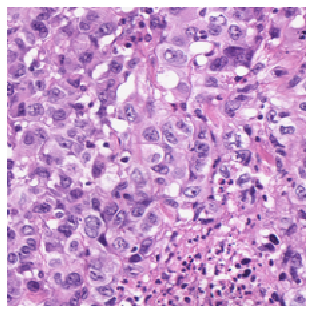

In [ ]:
plt.imshow(non_single_class_images[0])
plt.grid(False)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

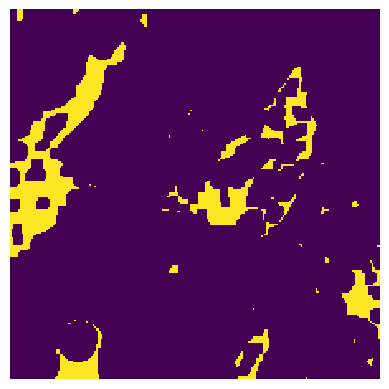

In [ ]:
plt.imshow(create_background_mask_two(only_tumour_i[50],224))
plt.grid(False)
plt.axis('off')


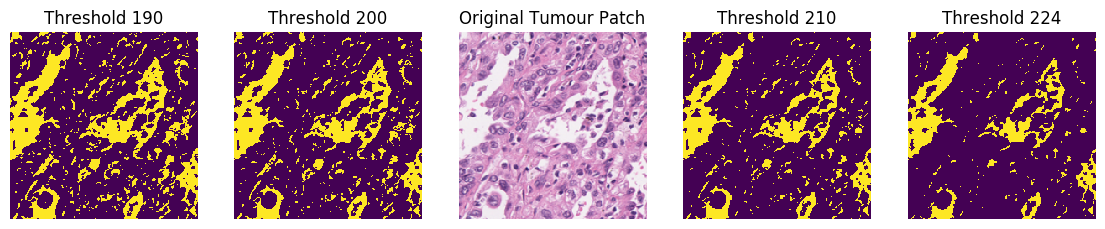

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(14,7))  # 1 row, 2 columns
grid='false'
ax[0].grid(False)
ax[0].set_title('Threshold 190')
ax[0].imshow(create_background_mask_two(only_tumour_i[50],190))
ax[0].axis('off')
ax[1].grid(False)
ax[1].axis('off')
ax[1].set_title('Threshold 200')
ax[1].imshow(create_background_mask_two(only_tumour_i[50],200))
ax[2].grid(False)
ax[2].axis('off')
ax[2].set_title('Original Tumour Patch')
ax[2].imshow(only_tumour_i[50])
ax[3].grid(False)
ax[3].axis('off')
ax[3].set_title('Threshold 210')
ax[3].imshow(create_background_mask_two(only_tumour_i[50],210))
ax[4].grid(False)
ax[4].axis('off')
ax[4].set_title('Threshold 224')
ax[4].imshow(create_background_mask_two(only_tumour_i[50],224))

plt.show()

In [ ]:
create_background_mask_two(only_tumour_i[30],224)

(-0.5, 223.5, 223.5, -0.5)

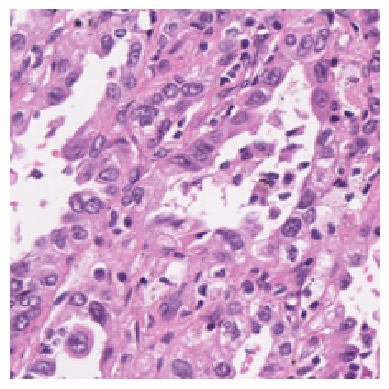

In [ ]:
plt.imshow(only_tumour_i[50])
plt.grid(False)
plt.axis('off')


In [ ]:
def create_background_mask(image):
  background_map =  np.zeros((224,224),dtype=np.uint8)
  kernel = np.ones((3,3),np.uint8)
  for i in range(224):
    for j in range(224):
      if all(pixel>= 224 for pixel in image[i][j]):
        background_map[i][j] = 255
      else:
        background_map[i][j] = 0
  closing = cv2.morphologyEx(background_map, cv2.MORPH_CLOSE, kernel)
  final = cv2.erode(closing,kernel,iterations = 1)

  return final 

In [ ]:
def make_mask_tumour(image):
  bg_mask = create_background_mask(image)
  image_mask = bg_mask.copy()
  for i in range(len(image_mask)):
    for j in range(len(image_mask[i])):
      if (image_mask[i][j]==255).all():
        image_mask[i][j] = 0
      else:
        image_mask[i][j] = 1
  return image_mask

In [ ]:
def make_mask_stroma(image):
  bg_mask = create_background_mask(image)
  image_mask = bg_mask.copy()

  for i in range(len(image_mask)):
    for j in range(len(image_mask[i])):
      if (image_mask[i][j]==255).all():
        image_mask[i][j] = 0
      else:
        image_mask[i][j] = 2
  return image_mask

In [ ]:
def make_mask_normal(image):
  bg_mask = create_background_mask(image)
  image_mask = bg_mask.copy()
  for i in range(len(image_mask)):
    for j in range(len(image_mask[i])):
      if (image_mask[i][j]==255).all():
        image_mask[i][j] = 0
      else:
        image_mask[i][j] = 3
  return image_mask

In [ ]:
def create_images_for_item(all_data,class_name):
  Masks = list()
  if class_name == 'tumour':
    for item in all_data:
      Masks.append(make_mask_tumour(item))
  elif class_name == 'stroma':
    for item in all_data:
      Masks.append(make_mask_stroma(item))
  elif class_name == 'normal':
    for item in all_data:
      Masks.append(make_mask_normal(item))
  return Masks

In [ ]:
tumour_masks = create_images_for_item(only_tumour_i,'tumour')

In [ ]:
stroma_masks = create_images_for_item(only_stroma_i,'stroma')

In [ ]:
normal_masks = create_images_for_item(only_normal_i,'normal')

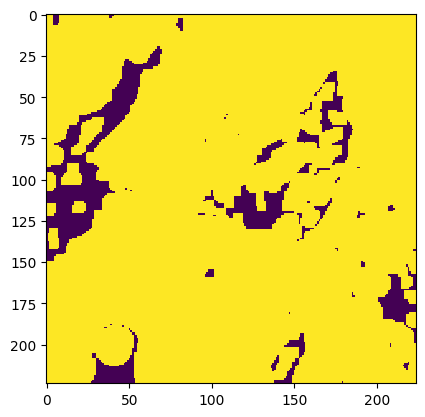

In [ ]:
plt.imshow(tumour_masks[50])


## GradCAM Mask Creation

In [ ]:
img_transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.ToTensor()
    ])

In [ ]:
def model_res(model):
  for param in model.parameters():
    param.requires_grad = True
  model.fc = nn.Linear(512,3)
  return model

In [ ]:
# Create training dataset for multi-label classification
class WSSS4LUAD_train(Dataset):
  def __init__(self,transform=None):
    self.x = np.array(non_single_class_images)
    self.labels = np.array(non_single_class_images_y)
    self.n_samples =  self.x.shape[0]
    self.transform = transform 

    #self.classes = list(set(self.y))
   
   
  def __getitem__(self,index):
    image = self.x[index]
    label = np.array(self.labels[index])
    if self.transform:
      image = self.transform(image)

    return image,label
  
  def __len__(self):
    return self.n_samples

In [ ]:
WSSS4LUAD_dataset_train = WSSS4LUAD_train(img_transform)
dataloader_WSSS4LUAD_train = DataLoader(dataset = WSSS4LUAD_dataset_train, batch_size = 1, shuffle = False)

In [ ]:
CAM_creation = [data for data in iter(dataloader_WSSS4LUAD_train)]

In [ ]:
# Get the models

class Res34(nn.Module):
    def __init__(self):
        super(Res34, self).__init__()
        
        # get the pretrained resnet34 network
        self.resnet34_LUAD = model_res(torchvision.models.resnet34(pretrained=True)).to(device)
        self.resnet34_LUAD.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet34_224.pth')['model_state_dict'])
        self.resnet34_LUAD.eval()
        
        # disect the network to access its last convolutional layer
        self.conv_layers = nn.Sequential(
        self.resnet34_LUAD.conv1,
        self.resnet34_LUAD.bn1,
        self.resnet34_LUAD.relu,
        self.resnet34_LUAD.maxpool,
        self.resnet34_LUAD.layer1,
        self.resnet34_LUAD.layer2,
        self.resnet34_LUAD.layer3,
        self.resnet34_LUAD.layer4
        )
          

        # get the max pool of the features stem
        self.GAP = self.resnet34_LUAD.avgpool
        
        # get the classifier of the vgg19
        self.classification = self.resnet34_LUAD.fc
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.conv_layers(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.GAP(x)
        x = x.view((1, -1))
        x = self.classification(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.conv_layers(x)


In [ ]:
def gain_class_related_heatmap(index, image, model):
  # Create model, Run prediction 
  pred = model(image.to(device))
  # Gain the CAM 
  pred[:, index].backward()
  gradients = model.get_activations_gradient()
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
  # get the activations of the last convolutional layer
  activations = model.get_activations(image.to(device)).detach()
  # weight the channels by corresponding gradients
  for i in range(512):
      activations[:, i, :, :] *= pooled_gradients[i]
  heatmap = torch.mean(activations, dim=1).squeeze()
  original_heatmap = np.maximum(heatmap.cpu(), 0)
  # normalize the heatmap
  original_heatmap /= torch.max(original_heatmap)
  # draw the heatmap
  return cv2.resize(original_heatmap.numpy(), (224, 224))


In [ ]:
hm = gain_class_related_heatmap(1,CAM_creation[0][0],Res34())

In [ ]:
# Resize images
#heatmap = cv2.resize(hm.numpy(), (224, 224))
# Convert to uint8
heatmap = np.uint8(255 * hm)
# Warm colour heatmap
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + non_single_class_images[0]

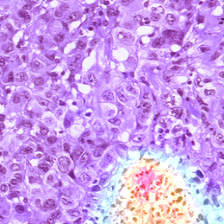

In [ ]:
cv2_imshow(superimposed_img)

In [ ]:
def gain_max_pixel(tissue_types, pixels):
 
  max_index = pixels.index(max(pixels))
  return tissue_types[max_index]

In [ ]:
def create_segmentation_mask(image,label, model):
  final_map = np.zeros((224,224),dtype=np.uint8)
  #print(final_map.shape)
  label = label.squeeze(0)
  predicted_class_indices = [i for i in range(len(label)) if label[i] ]
  class_heatmaps = dict()
  for i in range(len(predicted_class_indices)):
    if predicted_class_indices[i] == 0:
      class_heatmaps['tumour'] = gain_class_related_heatmap(predicted_class_indices[i], image,model)
    elif predicted_class_indices[i] == 1:
      class_heatmaps['stroma'] = gain_class_related_heatmap(predicted_class_indices[i], image,model)
    elif predicted_class_indices[i] == 2:
      class_heatmaps['normal'] = gain_class_related_heatmap(predicted_class_indices[i], image,model)  
  #print(class_heatmaps['tumour'])
  all_kp = list()
  class_winners = list()
  for i in range(224):
    for j in range(224):
      key_inputs = list()
      pixel_inputs = list()
      for key, im in class_heatmaps.items():
        key_inputs.append(key)
        pixel_inputs.append(im[i][j])

      class_winner = gain_max_pixel(key_inputs,pixel_inputs)
      class_winners.append(class_winner)
      #print(str(i),  str(j))
      #print(final_map[i][j])

      if class_winner == 'tumour':
        final_map[i,j] = 1
      elif class_winner == 'stroma':
        final_map[i,j] = 2
      elif class_winner == 'normal':
        final_map[i,j] = 3
  
  #print(pixel_inputs)

  return final_map 

  # Compare the heatmaps in values, we want to switch the values with the highest prediction on to the colour or turn them to 1 if that is not the case.


In [ ]:
new_seg_mask = create_segmentation_mask(CAM_creation[0][0],CAM_creation[0][1].numpy(),Res34())


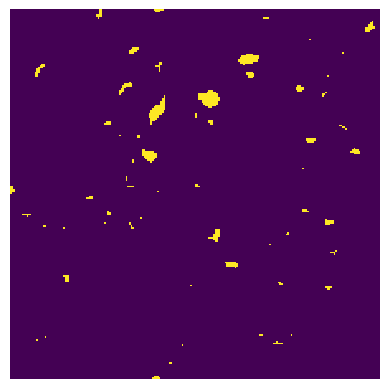

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(create_background_mask(non_single_class_images[0]))

In [ ]:
plt.style.use('default')

In [ ]:
def create_example(mask):
    mask = mask
    this_mask = np.zeros((mask.shape[0], mask.shape[1],3),dtype=np.uint8)
    for i in range(len(mask)):
      for j in range(len(mask[0])):
        if mask[i][j] == 0:
          this_mask[i][j] = [255,255,255]
        elif mask[i][j] == 1:
          this_mask[i][j] = [0,64,128]
        elif mask[i][j] == 2:
          this_mask[i][j] = [64,128,0]
        elif mask[i][j] == 3:
          this_mask[i][j] = [243,152,0]
    
    return this_mask 

(-0.5, 223.5, 223.5, -0.5)

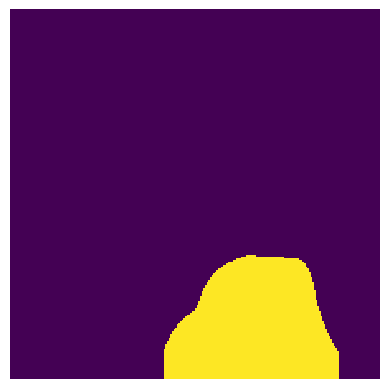

In [ ]:
plt.imshow(new_seg_mask)
plt.grid(False)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

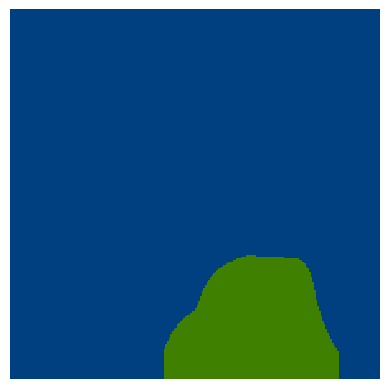

In [ ]:
plt.imshow(create_example(new_seg_mask))
plt.grid(False)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

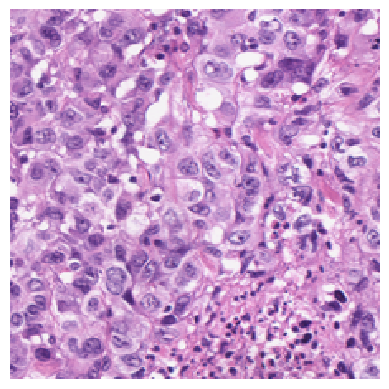

In [ ]:
plt.imshow(non_single_class_images[0])
plt.grid(False)
plt.axis('off')

In [ ]:
new = merge_background_and_colour_mask(new_seg_mask,create_background_mask(non_single_class_images[0]))


(-0.5, 223.5, 223.5, -0.5)

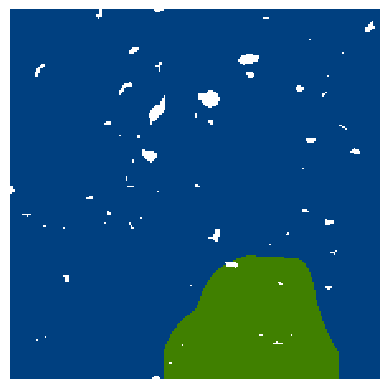

In [ ]:
plt.imshow(create_example(new))
plt.grid(False)
plt.axis('off')

In [ ]:
def merge_background_and_colour_mask(colour_mask, background_mask):
  for i in range(224):
    for j in range(224):
      if background_mask[i][j] == 255:
        colour_mask[i][j] = 0
  return colour_mask


In [ ]:
multi_class_masks = list()
res34model = Res34()
for i in range(len(non_single_class_images)):
  color_mask = create_segmentation_mask(CAM_creation[i][0],CAM_creation[i][1].numpy(),res34model)
  background_mask = create_background_mask(non_single_class_images[i])
  multi_class_masks.append(merge_background_and_colour_mask(color_mask,background_mask))

KeyboardInterrupt: ignored

In [ ]:
plt.imshow(multi_class_masks[40])

IndexError: ignored

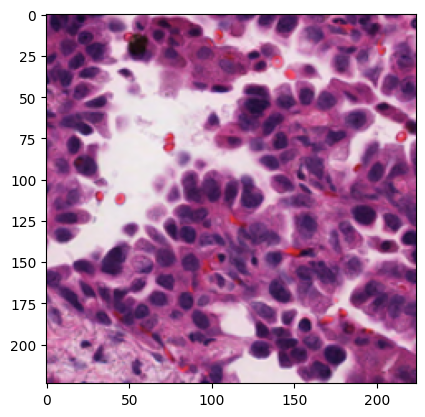

In [ ]:
plt.imshow(non_single_class_images[40])

In [ ]:
for i in range(len(non_single_class_images)):
  number = str(i)
  with open('/content/gdrive/MyDrive/non_single_class/masks/'+number+'.npy', 'wb') as f:
      np.save(f, multi_class_masks[i])

In [ ]:
!unzip "/content/gdrive/MyDrive/non_single_class.zip" -d "/content"


In [ ]:
multi_class_masks = list()
for i in range(len(non_single_class_images)):
  number = str(i)
  multi_class_masks.append(np.load('/content/non_single_class/masks/'+number+'.npy'))

## CutMix

In [ ]:
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """

    # Generate random bounding box inside area 
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

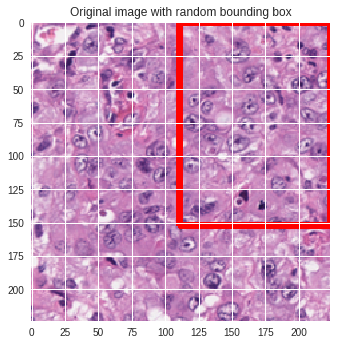

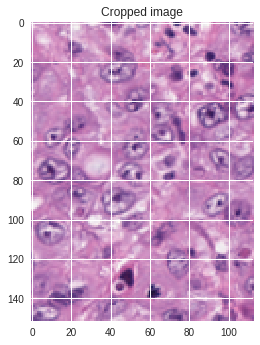

In [ ]:
image = only_tumour_i[25]

# Crop a random bounding box
lamb = 0.3
size = image.shape
#padding = get_padding(image)
bbox = rand_bbox(size, lamb)

# Draw bounding box on the image
im = image.copy()
x1 = bbox[0]
y1 = bbox[1]
x2 = bbox[2]
y2 = bbox[3]
cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 3)
plt.imshow(im);
plt.title('Original image with random bounding box')
plt.show();

# Show cropped image
plt.imshow(image[y1:y2, x1:x2]);
plt.title('Cropped image')
plt.show()

In [ ]:
def generate_cutmix_image(image_one,image_one_mask, image_two, image_two_mask, beta):
    ## Generate cutmix image specifically for one image at a time. 
    # generate mixed sample
    lam = np.random.beta(beta, beta)
 
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_one.shape, lam)
    #raw_image = cv2.resize(image_two,(224,224))

    image_batch_updated = image_one.copy()
    image_batch_updated[bbx1:bbx2, bby1:bby2, :] = image_two[bbx1:bbx2, bby1:bby2, :]

    image_batch_mask_updated = image_one_mask.copy()
    image_batch_mask_updated[bbx1:bbx2, bby1:bby2] = image_two_mask[bbx1:bbx2, bby1:bby2]

    
    return image_batch_updated, image_batch_mask_updated

In [ ]:
def produce_all_cutmix_images(tumour, stroma, normal, tumour_masks, stroma_masks, normal_masks):
  pairings = [[(tumour[:900],tumour_masks[:900]),(normal[:900],normal_masks[:900])], [(stroma[:900],stroma_masks[:900]), (normal[900:],normal_masks[900:])]]
  cutmix_images = list()
  cutmix_masks = list()
  for pair in pairings:
    print(len(pair[0][0]))

    for i in range(900):
      
      cutmix_image, cutmix_mask = generate_cutmix_image(pair[0][0][i],pair[0][1][i], pair[1][0][i],pair[1][1][i],1.0)
      cutmix_images.append(cutmix_image)
      cutmix_masks.append(cutmix_mask)


  return cutmix_images, cutmix_masks


In [ ]:
cutmix_images,cutmix_masks = produce_all_cutmix_images(only_tumour_i, only_stroma_i, only_normal_i, tumour_masks, stroma_masks, normal_masks )

900
900


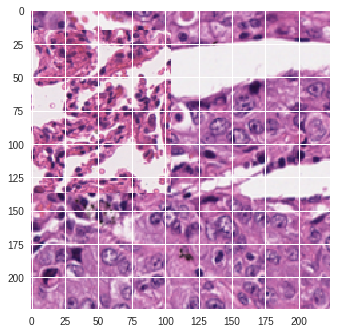

In [ ]:
plt.imshow(cutmix_images[20])

In [ ]:
final_training_x = list()
final_training_masks = list()


final_training_x.extend(only_tumour_i)
final_training_x.extend(only_stroma_i)
final_training_x.extend(only_normal_i)
final_training_x.extend(non_single_class_images)
final_training_x.extend(cutmix_images)



final_training_masks.extend(tumour_masks)
final_training_masks.extend(stroma_masks)
final_training_masks.extend(normal_masks)
final_training_masks.extend(multi_class_masks)
final_training_masks.extend(cutmix_masks)


In [ ]:
len(final_training_x)

11891

In [ ]:
for i in range(len(final_training_x)):
  number = str(i)
  with open('/content/gdrive/MyDrive/Train_full_cmix/images/'+number+'.npy', 'wb') as f:
      np.save(f, final_training_x[i])

  with open('/content/gdrive/MyDrive/Train_full_cmix/masks/'+number+'.npy', 'wb') as f:
      np.save(f, final_training_masks[i])


